<a href="https://colab.research.google.com/github/jmellafe/question_deduplication/blob/master/Copie_de_NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing and Exploring the dataset




In [1]:
import numpy as np
np.random.seed(2018)
from collections import Counter
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.metrics import log_loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
import sklearn.svm as svm
from sklearn.metrics import roc_auc_score, confusion_matrix

#Loading gensim and nltk libraries

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from gensim.corpora import Dictionary

import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')


from numpy.random import seed
seed(42)
from tensorflow import set_random_seed
set_random_seed(42)

# File paths
TRAIN_CSV = '/content/gdrive/My Drive/KTH courses/P4/NLP Language processing/project/data/train.csv'
TEST_CSV = '/content/gdrive/My Drive/KTH courses/P4/NLP Language processing/project/data/test.csv'
EMBEDDING_FILE = '/content/gdrive/My Drive/KTH courses/P4/NLP Language processing/project/data/GoogleNews-vectors-negative300.bin.gz'
MODEL_SAVING_DIR = '/content/gdrive/My Drive/KTH courses/P4/NLP Language processing/project/Models/my_model.h5'


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
# import data from the drive 

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# Hend data importing cell 

df = pd.read_csv(TRAIN_CSV)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [0]:
# Shuffle the data

df = df.sample(frac=1, random_state = 0).reset_index(drop=True)

# Create train, validation and test datasets
train_portion = 0.7
val_portion = 0.15
test_portion = 0.15

train_idx = int(train_portion * df.shape[0])
val_idx = int((train_portion + val_portion) * df.shape[0])

train = df[:train_idx]
val = df[train_idx:val_idx]
test = df[val_idx:]

Class 0:  178510  Class1:  104493


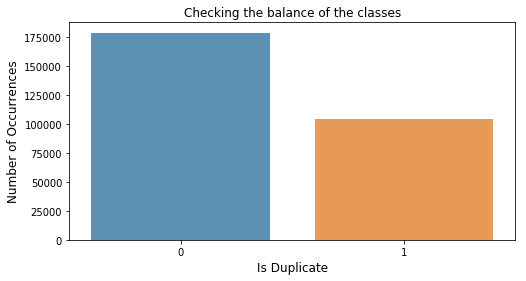

In [5]:
is_dup = train['is_duplicate'].value_counts()
print("Class 0: ", is_dup[0], " Class1: ", is_dup[1])
plt.figure(figsize=(8,4))
sns.barplot(is_dup.index, is_dup.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Is Duplicate', fontsize=12)
plt.title('Checking the balance of the classes')
plt.show()

In [0]:
# balancing the training set
class0 = train[train['is_duplicate']==0].sample(n=is_dup[1], random_state=1)
class1 = train[train['is_duplicate']==1]
train = pd.concat([class0, class1])
train = train.sample(frac=1, random_state = 0).reset_index(drop=True)


No handles with labels found to put in legend.


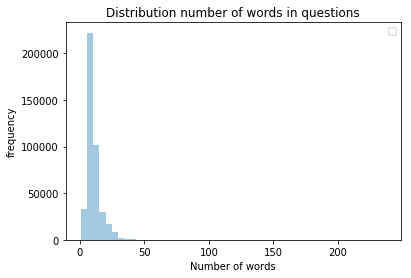

<Figure size 432x288 with 0 Axes>

In [7]:

# HIstogram number of words

temp = train['question1'].apply(lambda x: len(x.split()) if type(x) == str else np.nan)

temp2 = train['question2'].apply(lambda x: len(x.split()) if type(x) == str else np.nan)

temp = pd.concat([temp, temp2]).dropna()

sns.distplot(temp, kde=False)
plt.legend()
plt.title("Distribution number of words in questions")
plt.xlabel("Number of words")
plt.ylabel("frequency")

plt.show()
plt.clf()


No handles with labels found to put in legend.


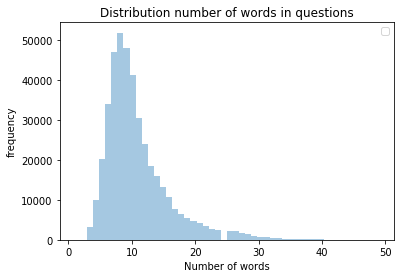

<Figure size 432x288 with 0 Axes>

In [8]:
# detail same plot
sns.distplot(temp[temp < 50], kde=False)
plt.legend()
plt.title("Distribution number of words in questions")
plt.xlabel("Number of words")
plt.ylabel("frequency")

plt.show()
plt.clf()

# 1.Random Forest

see papers: http://papers.www2017.com.au.s3-website-ap-southeast-2.amazonaws.com/proceedings/p1221.pdf 


In [0]:
# simple tokenization just to build the tf-idf feature vector, probably we should replace it for something fancier
train['q1_tokens'] = train['question1'].apply(lambda x: word_tokenize(x) if type(x)==str else np.nan)
train['q2_tokens'] = train['question2'].apply(lambda x: word_tokenize(x) if type(x)==str else np.nan)

In [0]:
dctr = Dictionary(train['q1_tokens'].dropna())
dctr.add_documents(train['q2_tokens'].dropna())

In [0]:
# preparing the features 

#series of all the questions in the training set 
train_qs = pd.Series(train['question1'].tolist() + train['question2'].tolist()).astype(str)
print("Question: ",train_qs[1])

#length of the questions provided in the train set
len_qs_train = train_qs.apply(lambda x: len(x.split(' ')))
print("lengh of the question: ",len_qs_train[1])

qmarks = np.mean(train_qs.apply(lambda x: '?' in x))
print("The pourcentage of questions including '?' : ",qmarks)

fullstop = np.mean(train_qs.apply(lambda x: '.' in x))
print("The pourcentage of questions including '.' : ",fullstop)

capital_first = np.mean(train_qs.apply(lambda x: x[0].isupper()))
print("The pourcentage of questions starting with a capital letter is: ",capital_first)

capitals = np.mean(train_qs.apply(lambda x: max([y.isupper() for y in x])))
print("The pourcentage of questions including capital letters : ",capitals)

numbers = np.mean(train_qs.apply(lambda x: max([y.isdigit() for y in x])))
print("The mean max numbers of digits in  of questions including numbers : ",numbers)


In [0]:
# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=1):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

stops = set(stopwords.words('english'))


def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    
    return R


def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R
  

  

In [0]:
df = pd.concat([train, val, test])

stemmer = SnowballStemmer("english") # Choose a language
qwords_special = ['what', 'who', 'when', 'where', 'why', 'which', 'how', 'whom', 'whose','no','not']

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    if text:
        text = str(text)
    for token in gensim.utils.simple_preprocess(text):
        if (token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3) or (token in qwords):
            result.append(lemmatize_stemming(token))
    return result

processed_q1 = df['question1'].map(preprocess)
processed_q2 = df['question2'].map(preprocess)

In [0]:
train_word_match = train.apply(word_match_share, axis=1, raw=True)
tfidf_train_word_match = train.apply(tfidf_word_match_share, axis=1, raw=True)


x_train = pd.DataFrame()
x_train['word_match'] = train_word_match
x_train['tfidf_word_match'] = tfidf_train_word_match
x_train['id'] = train['id']
x_train['is_duplicate'] = train['is_duplicate']

y_train = train['is_duplicate'].values




test_word_match = test.apply(word_match_share, axis=1, raw=True)
tfidf_val_word_match = test.apply(tfidf_word_match_share, axis=1, raw=True)
    
x_test = pd.DataFrame()
x_test['word_match'] = val_word_match
x_test['tfidf_word_match'] = tfidf_val_word_match
y_test = val['is_duplicate'].values
x_test['id'] = val['id']


predictors=['word_match','tfidf_word_match']
target='is_duplicate'


X_train= x_train[predictors]
y_train = x_train[target]
X_test=x_test[predictors]
#y_test = x_test[target]

#X=np.array(X).reshape(-1,1)
#y=np.array(y).reshape(-1,1)
#X= X.tolist()
#y= y.tolist()


def calculate_logloss(y_true, y_pred):
    loss_cal = log_loss(y_true, y_pred)
    return loss_cal


clf= RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=100, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, bootstrap=True, oob_score=True, n_jobs=1, random_state=1, verbose=1, warm_start=False, class_weight=None)
clf.fit(X_train,y_train)

accuracy=clf.score(X_test,y_test)
print("Random Forest",accuracy)
p=clf.predict_proba(X_test)

# 2. Siamese network 
https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d

https://becominghuman.ai/siamese-networks-algorithm-applications-and-pytorch-implementation-4ffa3304c18

## 2.1 Importing libraries 

In [9]:
# importing libraries 

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint


stops = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Using TensorFlow backend.


## 2.2 Creating Embedding Matrix

In [10]:
# Create embedding matrix

def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text) #delete special characters
    text = re.sub(r"what's", "what is ", text) # replace what's by what is
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

# Prepare embedding
vocabulary = dict()
inverse_vocabulary = ['<unk>']  # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

questions_cols = ['question1', 'question2']

# Iterate over the questions of both training and test sets
for dataset in [train,val,test]:
    for index, row in dataset.iterrows():

        # Iterate through the text of both questions of the row
        for question in questions_cols:

            q2n = []  # q2n -> question numbers representation
            for word in text_to_word_list(row[question]):

                # Check for unwanted words
                if word in stops and word not in word2vec.vocab:
                    continue

                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    q2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    q2n.append(vocabulary[word])

            # Replace questions as word to question as number representation
            dataset.set_value(index, question, q2n)
            
embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored

# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)

del word2vec

file = '/content/gdrive/My Drive/KTH courses/P4/NLP Language processing/project/Models/embedding_array.npy'
np.save(file, embeddings) # save
embeddings = np.load(file) # load



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [0]:
# load the embeddings
file = '/content/gdrive/My Drive/KTH courses/P4/NLP Language processing/project/Models/embedding_array.npy'
embeddings = np.load(file) # load

## 2.3 Preparing the input data 

In [0]:
max_seq_length = max(train.question1.map(lambda x: len(x)).max(),
                     train.question2.map(lambda x: len(x)).max(),
                     val.question1.map(lambda x: len(x)).max(),
                     val.question2.map(lambda x: len(x)).max(),
                     test.question1.map(lambda x: len(x)).max(),
                     test.question2.map(lambda x: len(x)).max())

# Prepare train and validation data to the wanted format
X_train = train[questions_cols]
Y_train = train['is_duplicate']

X_validation = val[questions_cols]
Y_validation = val['is_duplicate']



# Split to dicts
X_train = {'left': X_train.question1, 'right': X_train.question2}
X_validation = {'left': X_validation.question1, 'right': X_validation.question2}
X_test = {'left': test.question1, 'right': test.question2}

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values
Y_test = test['is_duplicate'].values
# Zero padding
for dataset, side in itertools.product([X_train, X_validation, X_test], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)


## 2.4 Build and save the model

In [12]:
!sudo pip install h5py

In [20]:
# Build the model


# Model variables
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 500 # prevously 64
n_epoch = 12

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Calculates the distance as defined by the MaLSTM model
malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adadelta(clipnorm=gradient_clipping_norm)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# Start training
training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

malstm.save(MODEL_SAVING_DIR)  # creates a HDF5 file 'my_model.h5'
print("Model saved")

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(malstm_trained.history)

# save to csv: 
hist_csv_file = '/content/gdrive/My Drive/KTH courses/P4/NLP Language processing/project/Models/history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)
print("History saved")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 208986 samples, validate on 60643 samples
Epoch 1/12
208986/208986 [==============================] - 276s 1ms/step - loss: 0.2322 - acc: 0.6577 - val_loss: 0.1978 - val_acc: 0.7235
Epoch 2/12
208986/208986 [==============================] - 272s 1ms/step - loss: 0.1996 - acc: 0.7140 - val_loss: 0.1886 - val_acc: 0.7374
Epoch 3/12
208986/208986 [==============================] - 267s 1ms/step - loss: 0.1879 - acc: 0.7360 - val_loss: 0.1843 - val_acc: 0.7397
Epoch 4/12
208986/208986 [==============================] - 270s 1ms/step - loss: 0.1810 - acc: 0.7477 - val_loss: 0.1742 - val_acc: 0.7530
Epoch 5/12
208986/208986 [==============================] - 271s 1ms/step - loss: 0.1765 - acc: 0.7554 - val_loss: 0.1726 - val_acc: 0.7557
Epoch 6/12
208986/208986 [==============================] - 267s 1ms/step - loss: 0.1730 - acc: 0.7615 - val_loss: 0.1731 - val_acc: 0.7531
Epoch 7/12
208986/208986 [==============================] - 267s 1ms/step - loss: 0.1702 - acc: 0.7659 - val_

In [21]:
# evaluate loaded model on test data
score = malstm.evaluate([X_train['left'], X_train['right']], Y_train,batch_size=128, verbose=1)
print("The metrics: ",malstm.metrics_names)
print("%s: %.2f%%" % (malstm.metrics_names[1], score[1]*100))
print("%s: %.2f%%" % (malstm.metrics_names[0], score[0]*100))


208986/208986 [==============================] - 376s 2ms/step
The metrics:  ['loss', 'acc']
acc: 77.89%
loss: 16.10%


In [22]:
y_preds = malstm.predict([X_test['left'],X_test['right']], verbose = 1)
y_pred_hard = np.zeros(y_preds.shape[0])
y_pred_hard[y_preds[:, 0] >= 0.5] = 1


60644/60644 [==============================] - 432s 7ms/step


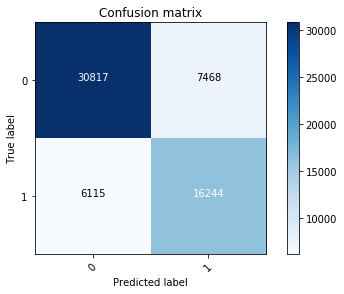

In [23]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Function from https://www.kaggle.com/danbrice/keras-plot-history-full-report-and-grid-search
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    
Y_test = test['is_duplicate'].values
cnf_matrix = confusion_matrix(Y_test,y_pred_hard)

plot_confusion_matrix(cnf_matrix,classes=[0,1])


In [26]:
from sklearn.metrics import accuracy_score

accuracy_score(Y_test,y_pred_hard)

0.7760207110348921

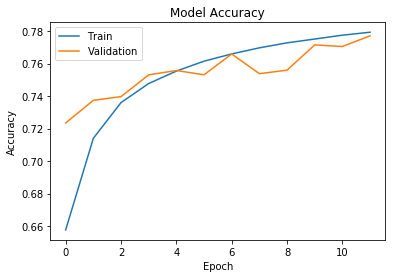

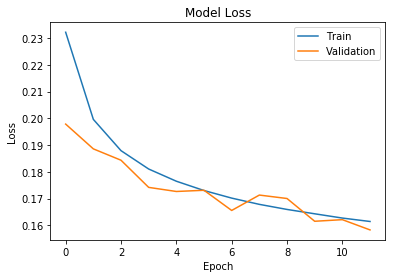

In [24]:
# Plotting the results


# Plot accuracy
plt.plot(malstm_trained.history['acc'])
plt.plot(malstm_trained.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()



## 2.5 Load the model

In [27]:
from keras.models import load_model

gradient_clipping_norm = 1.25

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adadelta(clipnorm=gradient_clipping_norm)

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))
# returns a compiled model
# identical to the previous one

model = load_model(MODEL_SAVING_DIR, custom_objects={'exponent_neg_manhattan_distance':exponent_neg_manhattan_distance})
print("Model loaded")

# evaluate loaded model on test data
# model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
score = model.evaluate([X_train['left'], X_train['right']], Y_train,batch_size=128, verbose=1)
print("The metrics: ",model.metrics_names)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

hist_csv_file = '/content/gdrive/My Drive/KTH courses/P4/NLP Language processing/project/Models/history.csv'
history_df = pd.read_csv(hist_csv_file)
#history_df['val_loss']



Model loaded
208986/208986 [==============================] - 388s 2ms/step
The metrics:  ['loss', 'acc']
acc: 77.89%


In [37]:
print(model.metrics_names)

['loss', 'acc']


In [36]:
y_preds = model.predict([X_test['left'],X_test['right']], verbose = 1)

60644/60644 [==============================] - 476s 8ms/step


In [38]:


    

y_pred_hard = np.zeros(y_preds.shape[0])
y_pred_hard[y_preds[:, 0] >= 0.5] = 1
cnf_matrix = confusion_matrix(Y_test,y_pred_hard)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,classes=[0,1])


print("Test Accuracy = %.6f"%accuracy_score(Y_test, y_preds))


NameError: ignored

## 2.6 Plotting the results

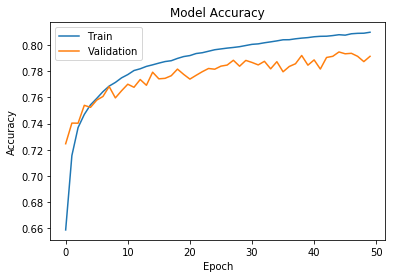

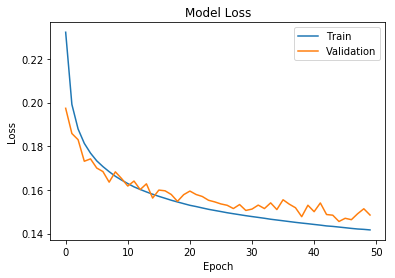

In [35]:
# Plotting the results


# Plot accuracy
plt.plot(history_df['acc'])
plt.plot(history_df['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history_df['loss'])
plt.plot(history_df['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

